Steps:
1. Get MNIST Dataset [👍]
2. Convert into train and test dataset [👍]
3. Make Convolution Model [👍]
4. Train Model [👍]
5. Check Metrics [👍]

### Imports
All the imports needed are:

In [59]:
import torchvision
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from helper_functions import train_step, test_step, save_model, print_train_time, accuracy_fn

import mlxtend, torchmetrics
import random

from timeit import default_timer as timer

torch.__version__

'2.3.1+cu121'

### Making device Agnostic Code:

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Breaking data down into train and test parts:

In [3]:
train_data = datasets.MNIST(
    root="data", 
    download=True,
    train=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data", 
    download=True,
    train=False,
    transform=ToTensor()
)

### Further breaking down Train and Test dataset into batches of size 32.

In [4]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data, 
                              batch_size=BATCH_SIZE,
                              shuffle=False)

In [5]:
print(f"Length of Train Dataloader: {len(train_dataloader)} of batch size {BATCH_SIZE}")
print(f"Length of Test Dataloader: {len(test_dataloader)} of batch size {BATCH_SIZE}")

Length of Train Dataloader: 1875 of batch size 32
Length of Test Dataloader: 313 of batch size 32


In [6]:
len(train_data), len(test_data)

(60000, 10000)

Visualizing data within the training dataset

(-0.5, 27.5, 27.5, -0.5)

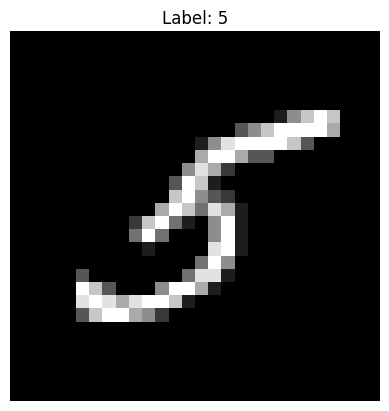

In [7]:
image, label = train_data[random.randint(1,100)]
plt.imshow(image[0], cmap='gray')
plt.title(f'Label: {label}')
plt.axis(False)

In [8]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Model Code:

In [30]:
class MNISTModel(nn.Module):
    def __init__(self, input_unit: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [31]:
model = MNISTModel(input_unit=1, hidden_units=10, output_shape=len(class_names)).to(device)

In [33]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

### Training Loop:

In [34]:
epochs = 3
model_start_time = timer()
for epoch in tqdm(range(epochs)):
    train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
model_end_time = timer()
print_train_time(start=model_start_time, end=model_end_time, device=device)

Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples
Train Loss: 0.3190927803516388 | Train Accuracy: 89.03%
Test Loss: 0.07786054164171219 | Test Accuracy: 97.45%
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples
Train Loss: 0.07577203214168549 | Train Accuracy: 97.61%
Test Loss: 0.059982772916555405 | Test Accuracy: 98.12%
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples
Train Loss: 0.06069411337375641 | Train Accuracy: 98.08%
Test Loss: 0.0461079403758049 | Test Accuracy: 98.52%
Total time on device cuda : 86.649 seconds


86.64882830006536

#### Saving Model Weights:

In [61]:
save_model(model=model, save_name="MNIST_Conv_Model_98.pth", model_path="models")

Saving Model to Path: models\MNIST_Conv_Model_98.pth


### Evaluation
Perform Evaluation by passing the path to image in the `image_path` variable

Text(0.5, 1.0, '4 - four')

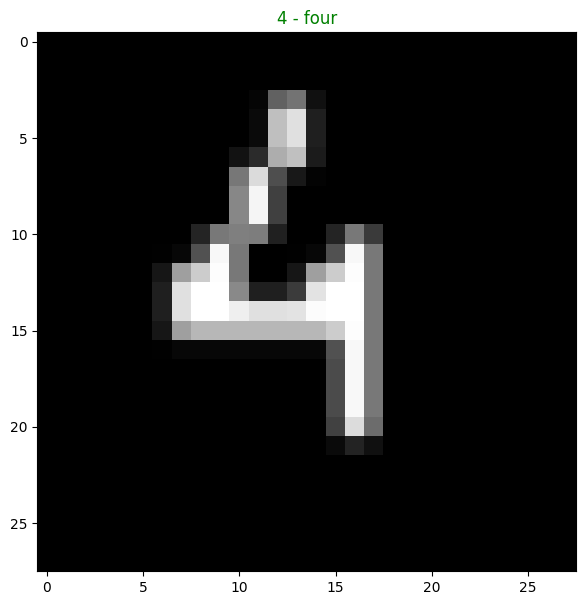

In [113]:
# Load your model
model.eval()

# Load the image
image_path = 'image/4.png'
img = Image.open(image_path).convert('L')  # Convert to grayscale

# Define the transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomInvert(1.0)
])

# Preprocess the image
img = transform(img)
img = img.unsqueeze(0)  # Add batch dimension
plt.figure(figsize=(15,7))
plt.imshow(img.squeeze(), cmap='gray')
# Make a prediction
img = img.to(device)
with torch.no_grad():
    outputs = model(img)
    _, predicted = torch.max(outputs, 1)
# print(f'Predicted label: {predicted.item()}, {train_data.classes[predicted.item()]}, {class_names}')
plt.title(train_data.classes[predicted.item()], c="green")


Testing Predictions ->:   0%|          | 0/313 [00:00<?, ?it/s]

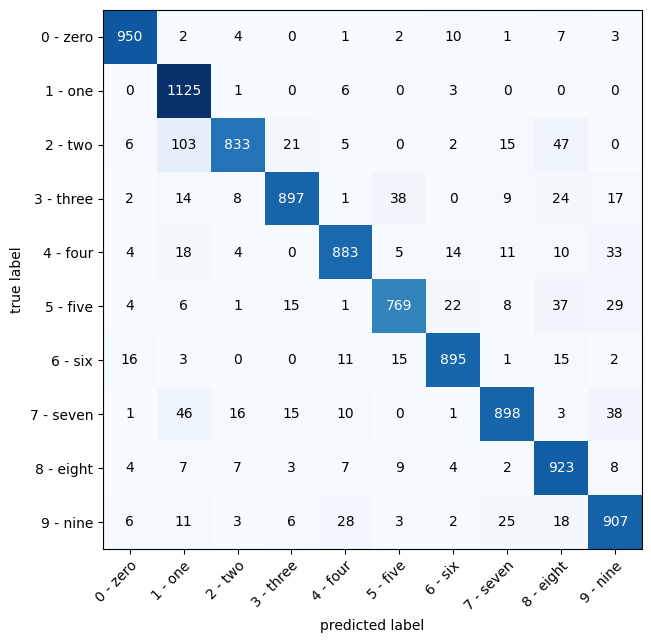

In [60]:
# Creating a confusion matrix for our most successful model yet: FashionMNISTV2 that uses Convolution.
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

y_preds = []

# Run test dataset through trained model and get the predictions and compare them with actual labels
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Testing Predictions ->"):
        # Sending data to gpu if available
        X, y = X.to(device), y.to(device)
        y_logits = model(X)

        # logits -> preds
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1   )
        
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(12,7)
)